# Implement Minimal Model Example
Test if model in README.md actually works

In [1]:
import xso
import numpy as np

@xso.component
class Variable:
    var = xso.variable(dims=[(), 'var'], description='basic state variable')
    
@xso.component
class LinearGrowth:
    var_ext = xso.variable(foreign=True, dims=[(), 'var'], flux='growth', description='external state variable')
    rate = xso.parameter(description='linear growth rate')
    @xso.flux(dims=[(), 'var'])
    def growth(self, var_ext, rate):
        return var_ext * rate + self.m.log(1)
    
model = xso.create({'Var':Variable,'Growth':LinearGrowth})

input_ds = xso.setup(solver='stepwise',
                     model=model,
                     time=np.arange(1,10),
                     input_vars={
                         'Var':{'var_label':'X', 'var_init':1},
                         'Growth':{'var_ext':'X', 'rate':1.},
                     })

with model:
    output_ds = input_ds.xsimlab.run()
    
print(output_ds)

input_ds = xso.setup(solver='odeint',
                     model=model,
                     time=np.arange(1,10),
                     input_vars={
                         'Var':{'var_label':'X', 'var_init':[1, 0.1]},
                         'Growth':{'var_ext':'X', 'rate':1.},
                     })

with model:
    output_ds = input_ds.xsimlab.run()
    

print(output_ds)

<class 'attr._make.Attribute'>
<class 'attr._make.Attribute'>
<class 'attr._make.Attribute'>
<class 'attr._make.Attribute'>
<class 'attr._make.Attribute'>
<class 'attr._make.Attribute'>
<xarray.Dataset>
Dimensions:               (time: 9, input_time: 9, clock: 9)
Coordinates:
  * clock                 (clock) int64 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: time, input_time
Data variables:
    Core__solver_type     <U8 'stepwise'
    Growth__growth_value  (time) float64 1.0 1.0 2.0 4.0 ... 32.0 64.0 128.0
    Growth__rate          float64 1.0
    Growth__var_ext       <U1 'X'
    Time__time            (input_time) int64 1 2 3 4 5 6 7 8 9
    Var__var_init         int64 1
    Var__var_label        <U1 'X'
    Var__var_value        (time) float64 1.0 2.0 4.0 8.0 ... 64.0 128.0 256.0
<xarray.Dataset>
Dimensions:               (var: 2, time: 9, input_time: 9, clock: 2)
Coordinates:
  * clock                 (clock) int64 1 2
Dimensions without coordinates: var, time, input_time
Data

# DETAILED STEPS

In [1]:
import xso
import xsimlab as xs

import numpy as np

In [2]:
@xso.component
class Variable:
    var = xso.variable(description='basic state variable')

In [3]:
@xso.component
class LinearGrowth:
    var_ext = xso.variable(foreign=True, flux='growth', description='external state variable')
    rate = xso.parameter(description='linear growth rate')

    @xso.flux
    def growth(self, var_ext, rate):
        return var_ext * rate

In [4]:
model = xso.create({'Var':Variable,'Growth':LinearGrowth})

In [5]:
print(model)

<xsimlab.Model (5 processes, 6 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) sequence of time points fo...
Var
    var_label       [in] label / basic state variable
    var_init        [in] initial value / basic state variable
Growth
    var_ext         [in] label reference / external state variable
    rate            [in] linear growth rate
Solver



In [6]:
input_ds = xso.setup(solver='odeint',
                     model=model,
                     time=np.arange(1,10,.1),
                     input_vars={
                         'Var':{'var_label':'X', 'var_init':1},
                         'Growth':{'var_ext':'X', 'rate':1.},
                     })

In [7]:
with model:
    output_ds = input_ds.xsimlab.run()

In [8]:
output_ds

<xarray.Dataset>
Dimensions:               (time: 90, input_time: 90, clock: 2)
Coordinates:
  * clock                 (clock) float64 1.0 1.1
Dimensions without coordinates: time, input_time
Data variables:
    Core__solver_type     <U6 'odeint'
    Growth__growth_value  (time) float64 1.052 1.052 ... 6.313e+03 6.977e+03
    Growth__rate          float64 1.0
    Growth__var_ext       <U1 'X'
    Time__time            (input_time) float64 1.0 1.1 1.2 1.3 ... 9.7 9.8 9.9
    Var__var_init         int64 1
    Var__var_label        <U1 'X'
    Var__var_value        (time) float64 1.0 1.105 1.221 ... 6.634e+03 7.332e+03

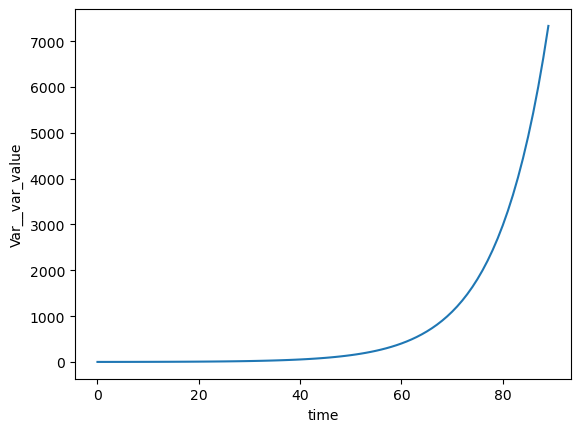

In [9]:
output_ds.Var__var_value.plot()

# Now let's try out the fancy stuff and put that into the readme

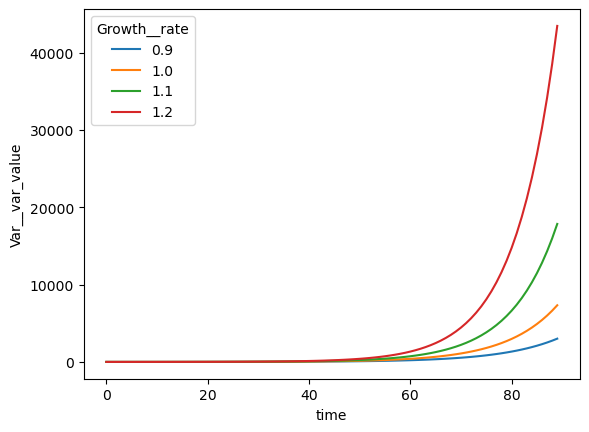

In [13]:
with model:
    batchout_ds = (input_ds
     .xsimlab.update_vars(
         input_vars={'Growth': {'rate': ('batch', [0.9, 1.0, 1.1, 1.2])}}
     )
     .xsimlab.run(parallel=True, batch_dim='batch')
     .swap_dims({'batch':'Growth__rate'})
     .Var__var_value.plot.line(x='time')
     )

In [83]:
batchout_ds=batchout_ds.swap_dims({'batch':'Growth__rate'})

In [86]:
batchout_ds.Growth__rate

<xarray.DataArray 'Growth__rate' (Growth__rate: 4)>
array([0.9, 1. , 1.1, 1.2])
Coordinates:
  * Growth__rate  (Growth__rate) float64 0.9 1.0 1.1 1.2
Attributes:
    description:  linear growth rate

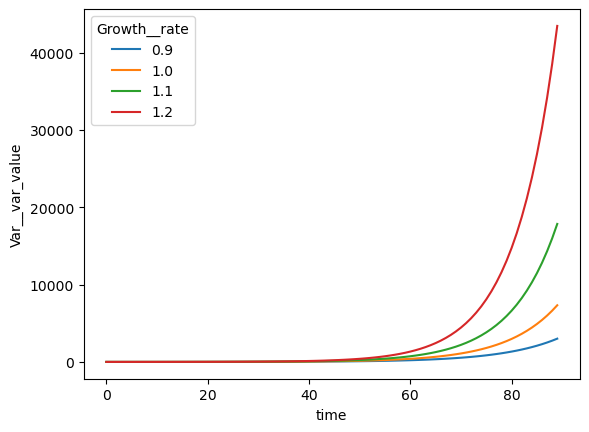

In [87]:
batchout_ds.Var__var_value.plot.line(x='time')


In [41]:
output.Growth__rate

<xarray.DataArray 'Growth__rate' (batch: 4)>
array([0.9, 1. , 1.1, 1.2])
Dimensions without coordinates: batch
Attributes:
    description:  linear growth rate

In [15]:
with model:
    input_ds.xsimlab.update_vars()